## Previsão de vendas com séries temporais

Este projeto foi desenvolvido com dados de unidades comercializadas de veículos, obtidos pelo [Portal de Dados Abertos](https://dados.gov.br/dados/conjuntos-dados/7384-vendas-de-veiculos-pelas-concessionarias-automoveis).

As vendas são contabilizadas quando os veículos são emplacados, o que gera uma Nota Fiscal de venda. As vendas podem ser diretas (com Nota Fiscal emitida por CNPJ de fabricante de veículos) ou a varejo (todos os outros casos).

A fonte original dos dados é a Fenabrave [ Federação Nacional da Distribuição de Veículos Automotores].

O objetivo deste projeto é treinar alguns modelos preditivos simples para séries temporais e selecionar aquele que resultará em menor erro de previsão.

Os dados de treino vão de fevereiro de 1990 a setembro de 2023, e os dados de treino vão de outubro de 2023 a setembro de 2024.

Os valores previstos pelo modelo poderão ser visualizados em um gráfico juntamente com as margens de erro.

Será feita uma previsão para os meses seguintes de 2024 e para todos os meses de 2025 com base no modelo treinado.

In [45]:
# Importando bibliotecas necessárias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from scipy import stats

import warnings

# Capturar avisos de convergência e tratá-los
warnings.filterwarnings("error", category=ConvergenceWarning)

In [46]:
# Lendo a base de dados

df = pd.read_csv("bcdata.sgs.7384.csv", sep = ";")
df.head()

,data,valor
0,01/02/1990,41228
1,01/03/1990,24353
2,01/04/1990,23705
3,01/05/1990,44062
4,01/06/1990,27130


In [47]:
# Verificar se existem valores nulos
sum(df['valor'].isna())

0

In [48]:
# Definindo os dados de vendas como uma série temporal

vendas_ts = pd.Series(df['valor'].values, index=pd.to_datetime(df['data'], format='%d/%m/%Y', dayfirst=True))
vendas_ts.index.freq = 'MS'
vendas_ts.head()

,0
data,
1990-02-01,41228
1990-03-01,24353
1990-04-01,23705
1990-05-01,44062
1990-06-01,27130


In [49]:
# Obtendo as estatísticas descritivas dos dados

vendas_ts.describe()

,0
count,416.000000
mean,137687.088942
std,57340.825738
min,23705.000000
25%,96885.000000
50%,129479.000000
75%,176214.500000
max,325722.000000


In [50]:
# verificar a última data

print(df.iloc[-1])

data     01/09/2024
valor        171658
Name: 415, dtype: object


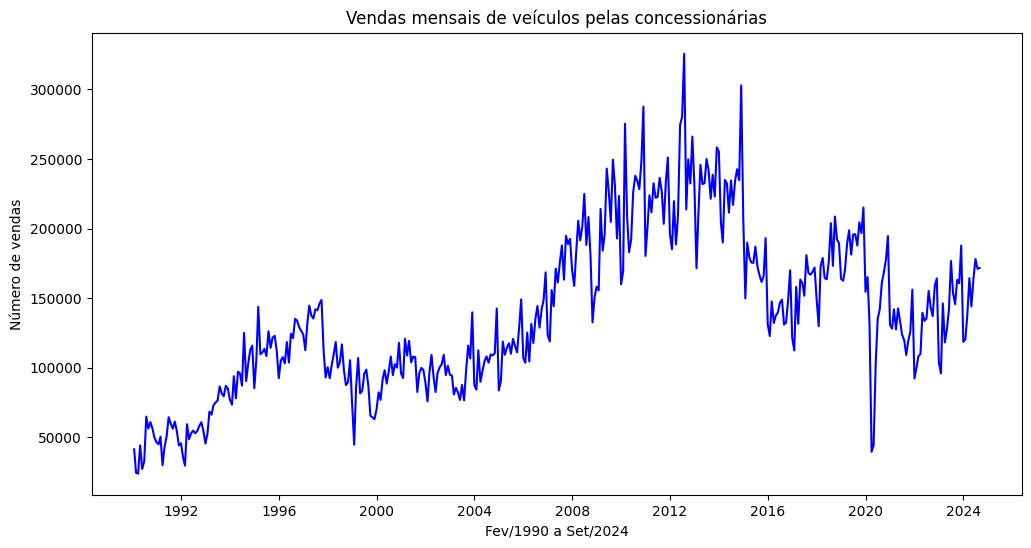

In [51]:
# Plotando o gráfico bruto

plt.figure(figsize=(12,6))
plt.plot(vendas_ts, color = "blue")
plt.title('Vendas mensais de veículos pelas concessionárias')
plt.xlabel('Fev/1990 a Set/2024')
plt.ylabel('Número de vendas')
plt.show()

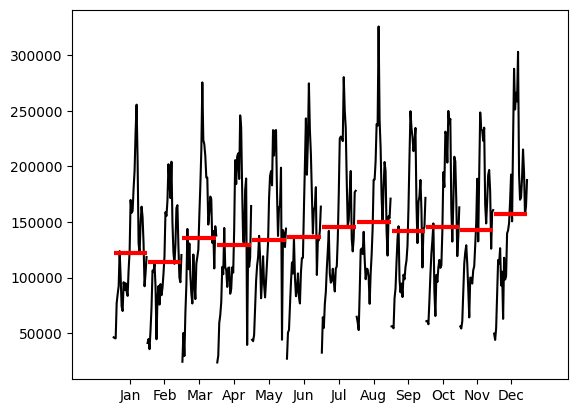

In [52]:
# Plotar a média de vendas por mês

sm.graphics.tsa.month_plot(vendas_ts)

plt.show()

Observa-se que a média de vendas aumenta ligeiramente ao longo do ano, exibindo menor valor em fevereiro e atingindo o seu pico em dezembro.

# Decomposição da série temporal

Ao observar o gráfico bruto, percebe-se que há variações sazonais. No entanto, estas variações parecem aumentar ao longo do tempo. Por isso, especula-se que os modelos multiplicativos terão uma melhor performance do que os modelos aditivos.

A decomposição da série temporal em seus componentes pode ajudar a decidir quais modelos preditivos mais se adequam aos dados.

Um modelo multiplicativo genérico consiste em:

Y = T x S x C x E

onde, Y é o valor da série no instante *t*, T é o componente de tendência para o instante *t*, S é o componente sazonal para o instante *t*, C é o componente cíclico para o instante *t* e E é o componente aleatório para o instante *t*.

Na decomposição a seguir, T e S são visualizados separadamente, enquanto C e E são visualizados juntos.




In [53]:
# Decomposição da série temporal pelo modelo multiplicativo

decomp_mul = seasonal_decompose(vendas_ts, model='multiplicative', period=12)

In [54]:
# Função para plotar a decomposição

def plot_decomposition(decomposition, title):
    colors = sns.color_palette("viridis", 4)

    plt.figure(figsize=(14, 10))
    plt.suptitle(title, fontsize=16)

    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observado', color=colors[0])
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Tendência', color=colors[1])
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Sazonalidade', color=colors[2])
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Resíduos', color=colors[3])
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


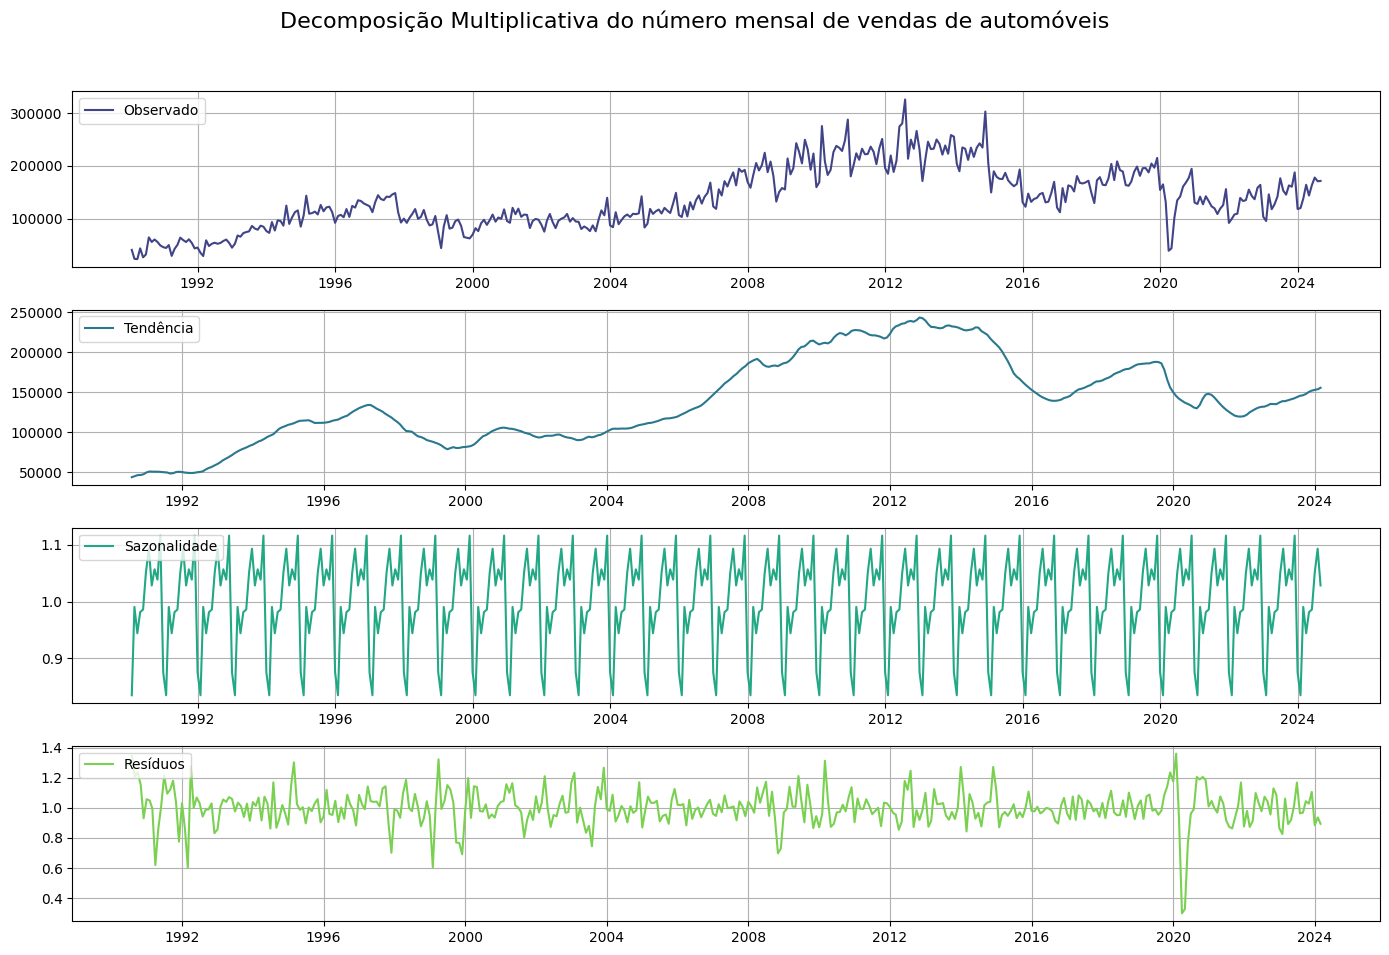

In [55]:
# Plotar decomposição multiplicativa

plot_decomposition(decomp_mul, 'Decomposição Multiplicativa do número mensal de vendas de automóveis')

## Treinamento de modelos

Serão utilizados modelos simples (Naive, Mean e Drift) e um modelo clássico (Suavização Exponencial de Holt-Winters). A estatística de erro das previsões que será utilizada para seleção do melhor modelo será o Mean Absolute Percentage Error [MAPE], uma métrica que quanto menor, melhor.

In [56]:
# Definir as datas para separar treino e teste

# Podemos reservar pelo menos 1 ciclo para o conjunto de teste e o restante, para o de treinamento

data_corte = df['data'].iloc[-12]
print(data_corte)

01/10/2023


In [57]:
# Separar a série em treino e teste usando as datas

vendas_treino = vendas_ts['1990-02-01':'2023-09-01']
vendas_teste = vendas_ts['2023-10-01':'2024-09-01']

# Exibir os tamanhos dos períodos de treino e teste
print(f"Período de Treino: {vendas_treino.index.min()} até {vendas_treino.index.max()} - {len(vendas_treino)} registros")
print(f"Período de Teste: {vendas_teste.index.min()} até {vendas_teste.index.max()} - {len(vendas_teste)} registros")


Período de Treino: 1990-02-01 00:00:00 até 2023-09-01 00:00:00 - 404 registros
Período de Teste: 2023-10-01 00:00:00 até 2024-09-01 00:00:00 - 12 registros


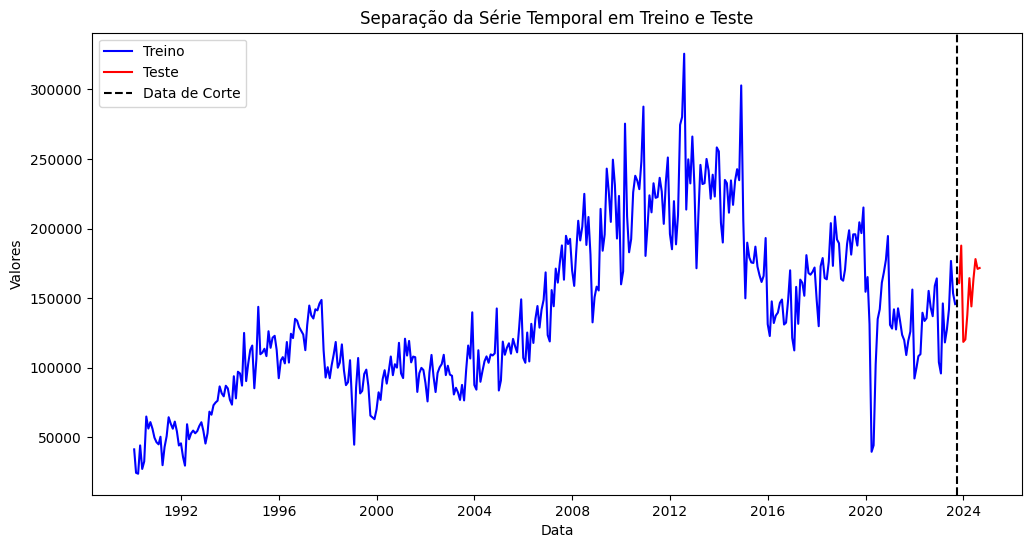

In [58]:
# Plotar períodos de treino e teste

plt.figure(figsize=(12,6))
plt.plot(vendas_treino, label='Treino', color='blue')
plt.plot(vendas_teste, label='Teste', color='red')
plt.axvline(pd.to_datetime(data_corte, format='%d/%m/%Y', dayfirst=True), color='black', linestyle='--', label='Data de Corte')
plt.title('Separação da Série Temporal em Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()


In [59]:
# Converter explicitamente para tipo numérico e garantir que são floats

vendas_treino = pd.to_numeric(vendas_treino, errors='coerce').astype(float)
vendas_treino.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 404 entries, 1990-02-01 to 2023-09-01
Freq: MS
Series name: None
Non-Null Count  Dtype  
--------------  -----  
404 non-null    float64
dtypes: float64(1)
memory usage: 6.3 KB


In [60]:
# Lista para armazenar os modelos, MAPE e previsões

modelos_vendas = []
mapes_vendas = []
previsoes_vendas = {}

In [61]:
# Modelo Naive

naive_forecast = pd.Series([vendas_treino.iloc[-1]] * len(vendas_teste), index=vendas_teste.index)
mape_naive = mape(vendas_teste, naive_forecast) * 100
modelos_vendas.append("Naive")
mapes_vendas.append(mape_naive)
previsoes_vendas["Naive"] = naive_forecast

In [62]:
# Modelo Mean (média)

mean_forecast = pd.Series(vendas_treino.mean(), index=vendas_teste.index)
mape_mean = mape(vendas_teste, mean_forecast) * 100
modelos_vendas.append("Mean")
mapes_vendas.append(mape_mean)
previsoes_vendas["Mean"] = mean_forecast

In [63]:
# Modelo Drift

n = len(vendas_treino)
drift_slope = (vendas_treino.iloc[-1] - vendas_treino.iloc[0]) / (n - 1)
drift_forecast = vendas_treino.iloc[-1] + drift_slope * np.arange(1, len(vendas_teste) + 1)
drift_forecast = pd.Series(drift_forecast, index=vendas_teste.index)
mape_drift_result = mape(vendas_teste, drift_forecast) * 100
modelos_vendas.append("Drift")
mapes_vendas.append(mape_drift_result)
previsoes_vendas["Drift"] = drift_forecast

In [64]:
# Modelo Naive Sazonal

naive_sazonal_forecast = pd.Series([vendas_treino.iloc[-12 + (i % 12)]
                                    for i in range(len(vendas_teste))],
                                   index=vendas_teste.index)
mape_naive_sazonal = mape(vendas_teste, naive_sazonal_forecast) * 100
modelos_vendas.append("Naive Sazonal")
mapes_vendas.append(mape_naive_sazonal)
previsoes_vendas["Naive Sazonal"] = naive_sazonal_forecast

In [65]:
# Holt-Winters Aditivo - Ajustar inicialização e Box-Cox para melhorar a convergência

try:
    hw_add_model = ExponentialSmoothing(
        vendas_treino,
        seasonal_periods=12,
        trend='add',
        seasonal='add',
        initialization_method="estimated",  # Método robusto de inicialização
        use_boxcox=True  # Tentar estabilizar a variância com Box-Cox
    ).fit(optimized=True)

    hw_add_forecast = hw_add_model.forecast(steps=len(vendas_teste))
    mape_hw_add = mape(vendas_teste, hw_add_forecast) * 100
    modelos_vendas.append("Holt-Winters Aditivo")
    mapes_vendas.append(mape_hw_add)
    previsoes_vendas["Holt-Winters Aditivo"] = hw_add_forecast
except Exception:
    modelos_vendas.append("Holt-Winters Aditivo")
    mapes_vendas.append(np.nan)


In [66]:
# Holt-Winters Multiplicativo - Ajustar inicialização e Box-Cox para melhorar a convergência

try:
    hw_mult_model = ExponentialSmoothing(
        vendas_treino,
        seasonal_periods=12,
        trend='add',
        seasonal='mul',
        initialization_method="estimated",  # Método robusto de inicialização
        use_boxcox=True  # Tentar estabilizar a variância com Box-Cox
    ).fit(optimized=True)

    hw_mult_forecast = hw_mult_model.forecast(steps=len(vendas_teste))
    mape_hw_mult = mape(vendas_teste, hw_mult_forecast) * 100
    modelos_vendas.append("Holt-Winters Multiplicativo")
    mapes_vendas.append(mape_hw_mult)
    previsoes_vendas["Holt-Winters Multiplicativo"] = hw_mult_forecast
except Exception:
    modelos_vendas.append("Holt-Winters Multiplicativo")
    mapes_vendas.append(np.nan)

In [67]:
# Comparação dos modelos com base no MAPE
mape_comparison = pd.DataFrame({'Modelo': modelos_vendas, 'MAPE': mapes_vendas})
mape_comparison = mape_comparison.sort_values(by='MAPE', ascending=True).reset_index(drop=True)
print(mape_comparison)

                        Modelo       MAPE
0  Holt-Winters Multiplicativo   5.291767
1         Holt-Winters Aditivo   8.263993
2                Naive Sazonal  12.300037
3                        Drift  13.333006
4                        Naive  13.652895
5                         Mean  15.698347


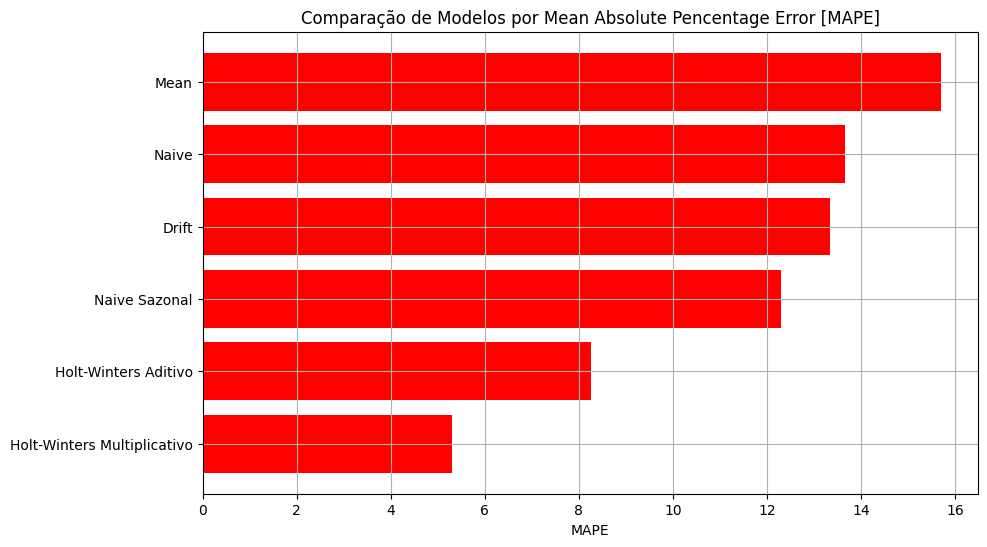

In [68]:
# Gráfico dos MAPE dos modelos
plt.figure(figsize=(10, 6))
plt.barh(mape_comparison['Modelo'], mape_comparison['MAPE'], color='red')
plt.xlabel("MAPE")
plt.title("Comparação de Modelos por Mean Absolute Pencentage Error [MAPE]")
plt.grid(True)
plt.show()

O melhor modelo foi o de Holt-Winters Multiplicativo, o qual alcançou MAPE de 5,29%.
Mais abaixo será testada a normalidade e a autocorrelação dos resíduos para verificar o ajuste do modelo.

In [69]:
print(hw_mult_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  404
Model:             ExponentialSmoothing   SSE                   147607681228.449
Optimized:                         True   AIC                           7997.429
Trend:                         Additive   BIC                           8061.452
Seasonal:                Multiplicative   AICC                          7999.206
Seasonal Periods:                    12   Date:                 Wed, 13 Nov 2024
Box-Cox:                           True   Time:                         01:11:27
Box-Cox Coeff.:                 0.53073                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5707133                alpha                 True
smoothing_trend          

Os coeficientes alpha, beta e gamma regulam o ajuste do modelo a mudanças ao longo dos dados históricos. Quanto mais próximo de 1, mais o modelo responde a dados recentes, e quanto mais próximo de 0, mais o modelo dá peso ao histórico completo da série.

In [70]:
# Selecionar o modelo com o menor MAPE

melhor_modelo = mape_comparison.loc[0, 'Modelo']
melhores_previsoes = previsoes_vendas[melhor_modelo]

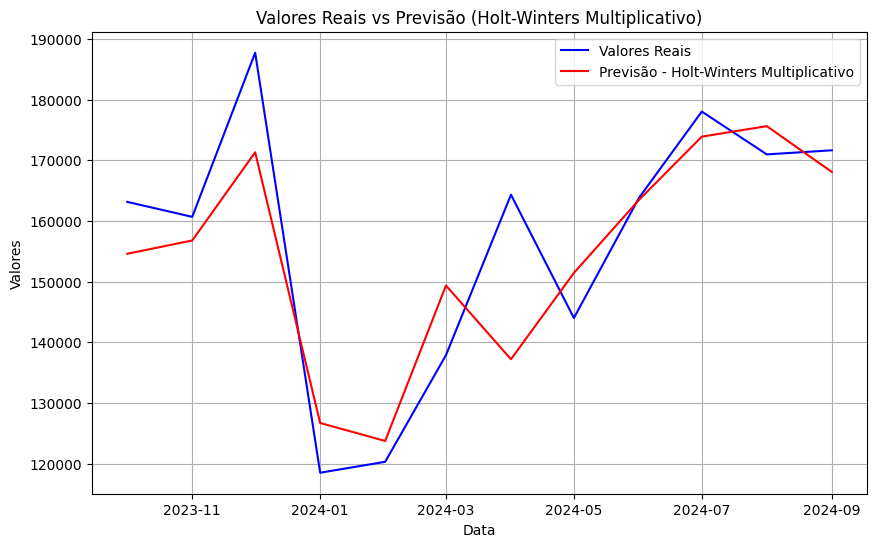

In [71]:
# Criar gráfico comparando os valores reais e previstos do melhor modelo

plt.figure(figsize=(10, 6))
plt.plot(vendas_teste.index, vendas_teste, label='Valores Reais', color='blue')
plt.plot(vendas_teste.index, melhores_previsoes, label=f'Previsão - {melhor_modelo}', color='red')
plt.title(f'Valores Reais vs Previsão ({melhor_modelo})')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# Cálculo dos resíduos do melhor modelo

residuos = vendas_teste - melhores_previsoes
print(residuos)

data
2023-10-01     8553.173336
2023-11-01     3896.464343
2023-12-01    16416.269994
2024-01-01    -8195.680612
2024-02-01    -3440.028686
2024-03-01   -11478.409399
2024-04-01    27122.739204
2024-05-01    -7429.554287
2024-06-01      338.324964
2024-07-01     4131.638693
2024-08-01    -4655.299797
2024-09-01     3565.369718
Freq: MS, dtype: float64


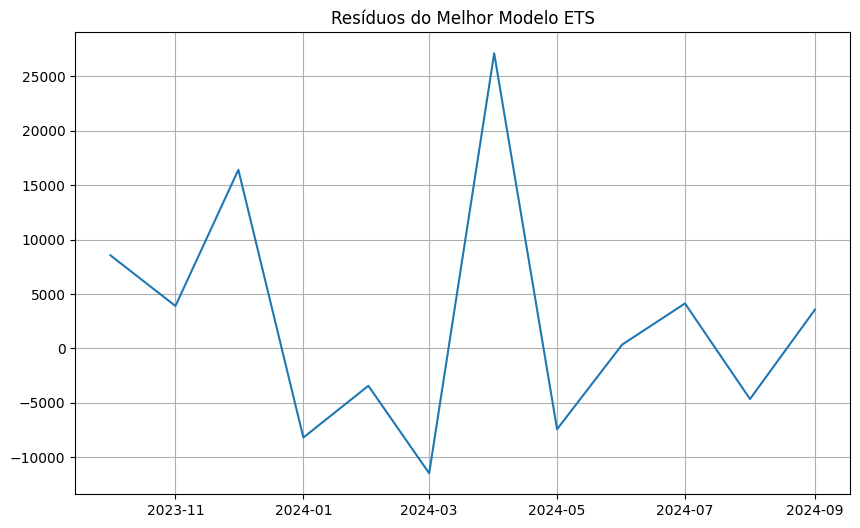

In [73]:
# Visualização dos resíduos

plt.figure(figsize=(10, 6))
plt.plot(residuos, label="Resíduos")
plt.title("Resíduos do Melhor Modelo ETS")
plt.grid(True)
plt.show()

In [74]:
# Teste de normalidade Shapiro-Wilk
stat, p_value_shapiro = shapiro(residuos)
print(f"Teste de Normalidade Shapiro-Wilk: Estatística={stat:.4f}, p-valor={p_value_shapiro:.4f}")
if p_value_shapiro > 0.05:
    print("Os resíduos parecem seguir uma distribuição normal (não rejeitamos H0).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos H0).")

Teste de Normalidade Shapiro-Wilk: Estatística=0.9254, p-valor=0.3340
Os resíduos parecem seguir uma distribuição normal (não rejeitamos H0).


In [75]:
# Testar para as defasagens de 1 a 6
lb_test = acorr_ljungbox(residuos, lags=[1, 2, 3, 6], return_df=True)
print(f"Teste Ljung-Box:\n{lb_test}")


Teste Ljung-Box:
    lb_stat  lb_pvalue
1  2.710534   0.099688
2  2.764713   0.250986
3  3.925555   0.269616
6  4.610915   0.594592


In [76]:
# Interpretação do teste de Ljung-Box
p_value_ljungbox = lb_test['lb_pvalue'].values.min()
if p_value_ljungbox > 0.05:
    print("Não há evidências de autocorrelação significativa nos resíduos (não rejeitamos H0).")
else:
    print("Há evidências de autocorrelação nos resíduos (rejeitamos H0).")

Não há evidências de autocorrelação significativa nos resíduos (não rejeitamos H0).


In [77]:
# Definindo o número de meses para prever além dos dados de teste

meses_previstos = len(vendas_teste)
meses_a_prever = 15

# Use o modelo já treinado para prever para novos meses
previsao_futura = hw_add_model.forecast(steps=meses_previstos + meses_a_prever)
previsao_futura = previsao_futura.iloc[-meses_a_prever:]

# Mostra as previsões para os próximos meses
print("Previsão para os próximos meses:", previsao_futura)


Previsão para os próximos meses: 2024-10-01    152924.007435
2024-11-01    152368.112719
2024-12-01    165550.363568
2025-01-01    120766.872895
2025-02-01    116748.090679
2025-03-01    141056.337500
2025-04-01    130040.691224
2025-05-01    142023.560370
2025-06-01    147492.571192
2025-07-01    155750.967726
2025-08-01    157058.686880
2025-09-01    148327.730562
2025-10-01    153415.148405
2025-11-01    152858.415783
2025-12-01    166060.118137
Freq: MS, dtype: float64


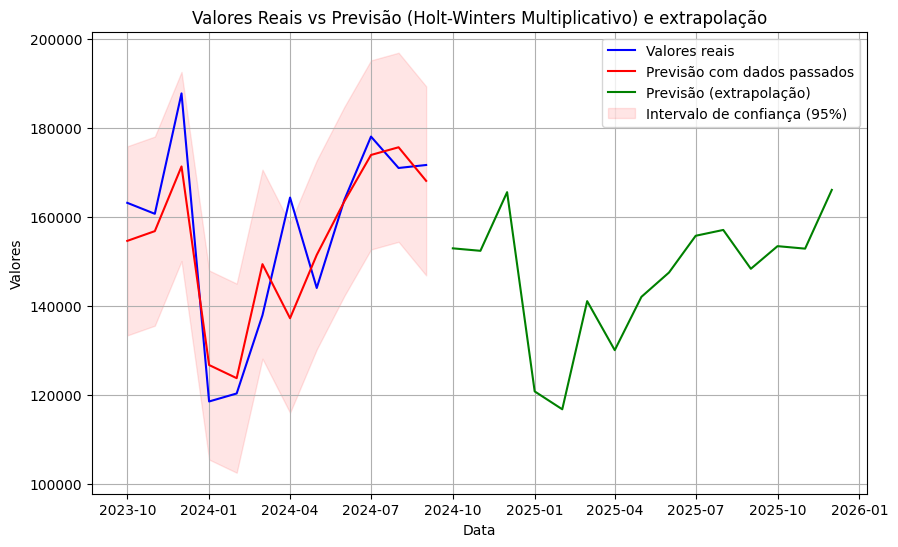

In [78]:
# Plotar série para os meses de 2024 e 2025

plt.figure(figsize=(10, 6))
plt.plot(vendas_teste.index, vendas_teste, label='Valores reais', color='blue')
plt.plot(vendas_teste.index, melhores_previsoes, label='Previsão com dados passados', color='red')
plt.plot(previsao_futura.index, previsao_futura, label='Previsão (extrapolação)', color='green')

# Plotar intervalos de confiança
confidence = 0.95
season_length = len(vendas_teste)
steps_ahead = len(vendas_teste)
forecast = melhores_previsoes.values

# Calcular o quadrado dos erros (resíduos)
errors2 = residuos ** 2

# Calcular o desvio padrão dos erros
std_residuals = np.sqrt(errors2.mean())

# Calcular o valor crítico z para o intervalo de confiança
z_value = stats.norm.ppf((1 + confidence) / 2)

# Calcular a margem de erro
margin_of_error = z_value * std_residuals

# Definir limites inferiores e superiores dos intervalos de confiança
lower_bound = [forecast[i] - margin_of_error * np.sqrt((i // season_length) + 1) for i in range(steps_ahead)]
upper_bound = [forecast[i] + margin_of_error * np.sqrt((i // season_length) + 1) for i in range(steps_ahead)]

# Adicionar o intervalo de confiança ao gráfico
plt.fill_between(vendas_teste.index, lower_bound, upper_bound, color='red', alpha=0.1, label='Intervalo de confiança (95%)')

plt.title(f'Valores Reais vs Previsão ({melhor_modelo}) e extrapolação')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()


Observa-se que a extrapolação capturou o comportamento sazonal observado ao longo do ano, pois os valores previstos na extrapolação (verde) são próximos aos observados (azul) e aos previstos com dados passados (vermelho).

O intervalo de confiança em torno da linha de previsão vermelha, delimitado pelo preenchimento vermelho transparente, indica a faixa de valores esperados para as vendas. Com um intervalo de confiança de 95%, esperamos que 95% das vezes os valores reais estejam dentro dessa faixa se repetíssemos o processo.

## Discussão

Este script também pode ser aplicado para previsão de vendas de produtos específicos, bastando apenas ter dados datados e fazendo as devidas adaptações para adequar o código às características dos dados (tamanho e número de ciclos, por exemplo). Pode ser necessário testar outros modelos que sejam mais adequados aos dados.

Neste projeto, foi utilizado o método de suavização exponecial de Holt-Winters [HW], adequado para séries com tendência e sazonalidade.

Para séries temporais sem tendência e sem sazonalidade, pode ser utilizado o método de suavização exponencial simples [SES].

Em caso de modelos com tendência mas sem sazonalidade, pode ser utilizado o método de suavização exponencial de Holt [SEH].

Caso seja necessário obter modelagens mais robustas, pode ser útil aplicar modelos mais complexos como AR, ARMA e ARIMA.